# Predicción de Accidentes Cerebrovasculares Utilizando Técnicas de Aprendizaje Automático

Victor de Marco y Alejandro Diez

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import clone
from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    RocCurveDisplay,
    ConfusionMatrixDisplay,
    classification_report,
)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

## Análisis Exploratorio de Datos

In [161]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

numeric_columns = ['age', 'avg_glucose_level', 'bmi']
categorical_columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [162]:
# Describir el DataFrame
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [163]:
# Mostrar información general del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [164]:
# Mostrar la cantidad de nulos
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### Distribución de la variable objetivo

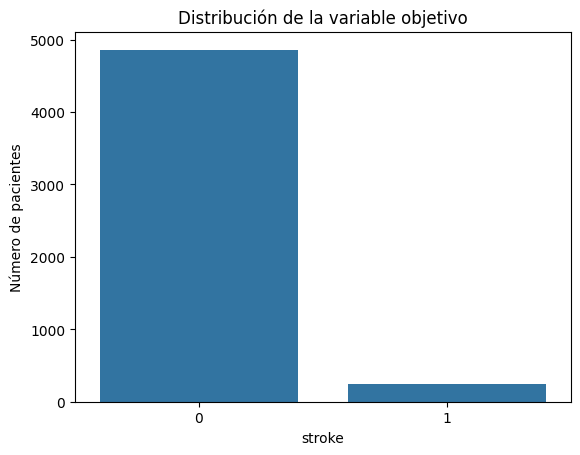

In [165]:
plt.figure()
sns.countplot(x="stroke", data=df)
plt.title("Distribución de la variable objetivo")
plt.ylabel("Número de pacientes")
plt.show()

### Variables numéricas

<Figure size 640x480 with 0 Axes>

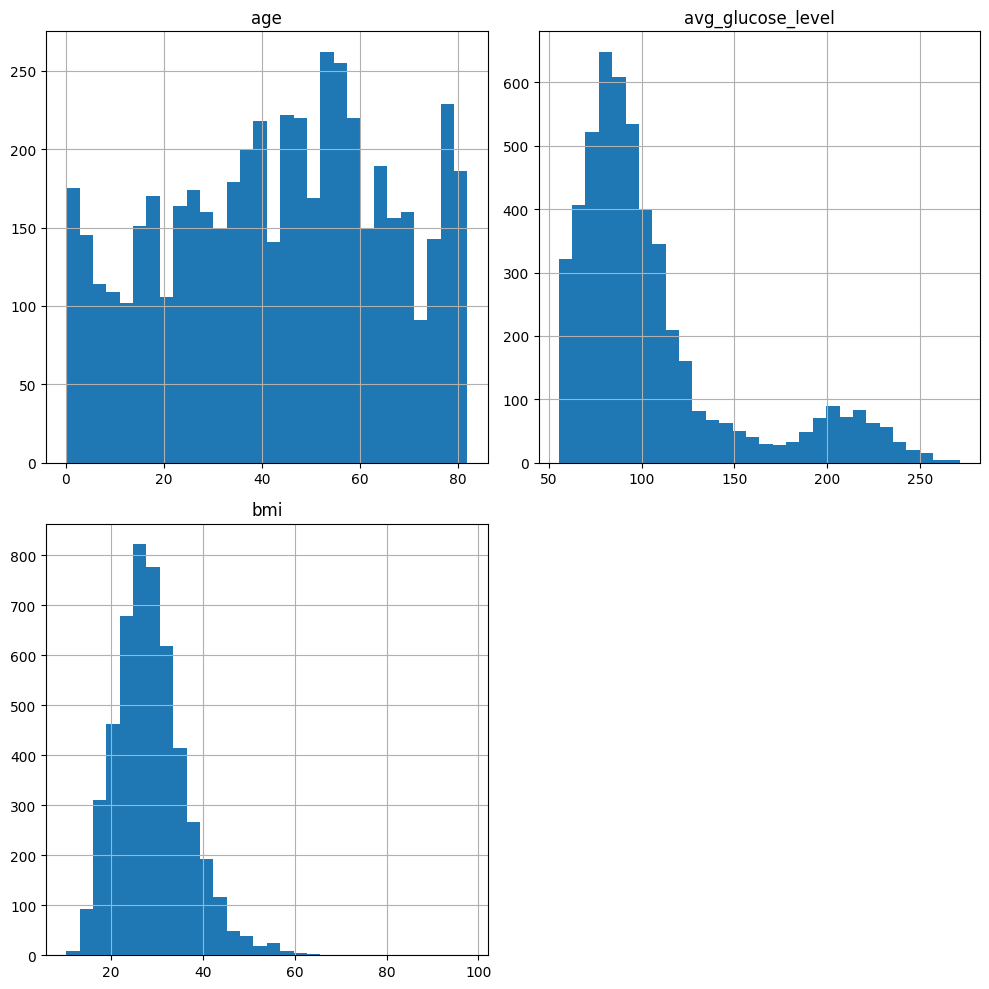

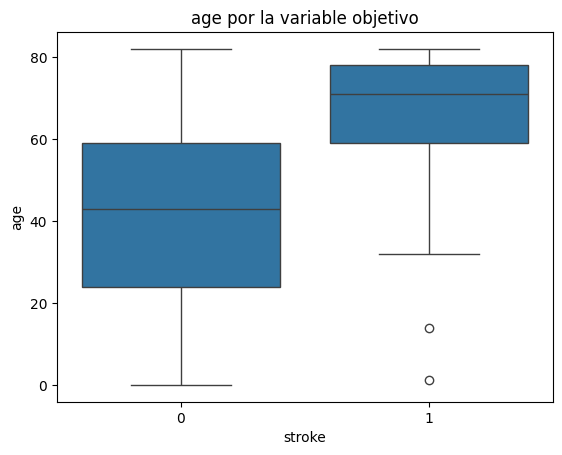

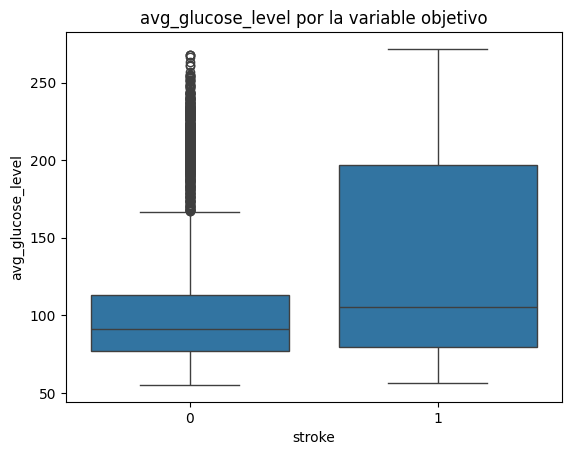

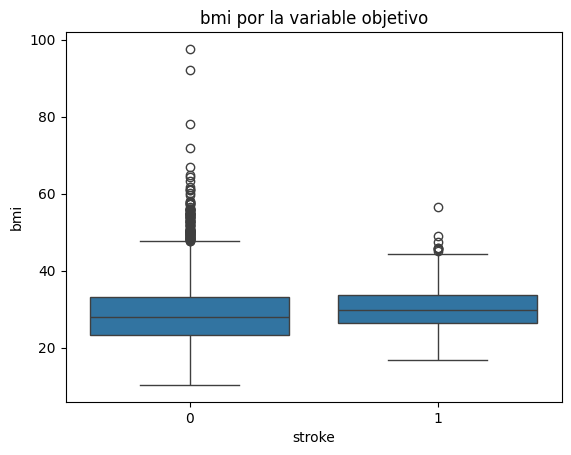

In [166]:
plt.figure()
df[numeric_columns].hist(figsize=(10, 10), bins=30)
plt.tight_layout()
plt.show()

for col in numeric_columns:
    plt.figure()
    sns.boxplot(x="stroke", y=col, data=df)
    plt.title(f"{col} por la variable objetivo")
    plt.show()

### Variables categóricas

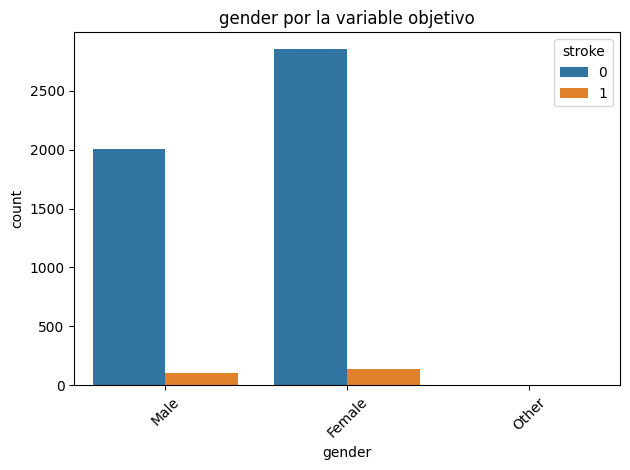

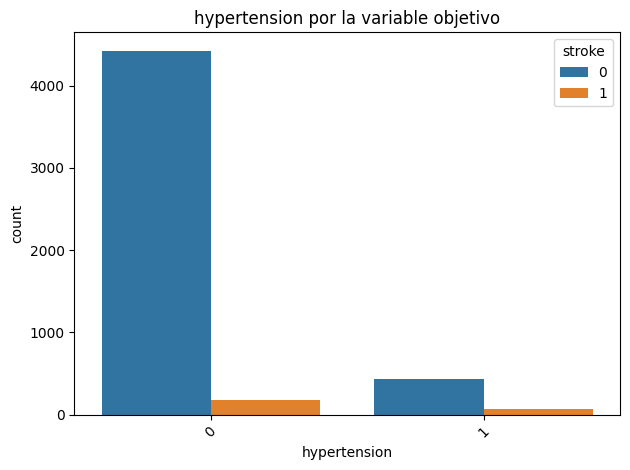

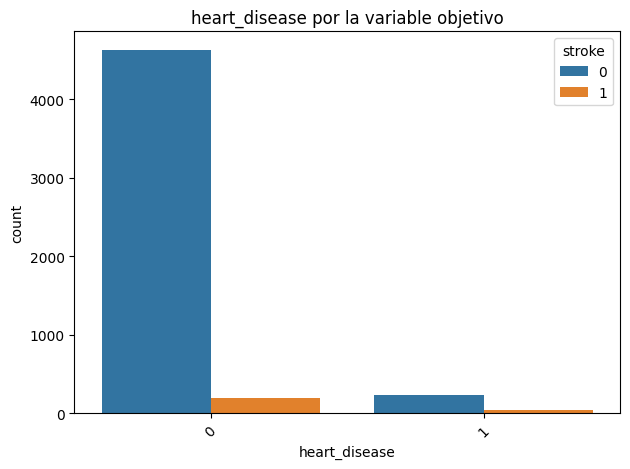

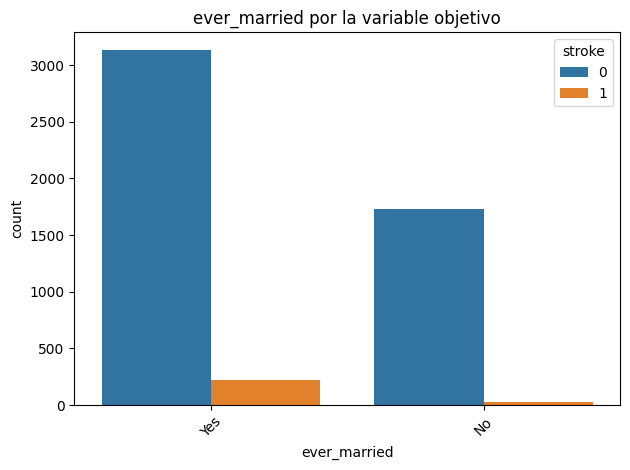

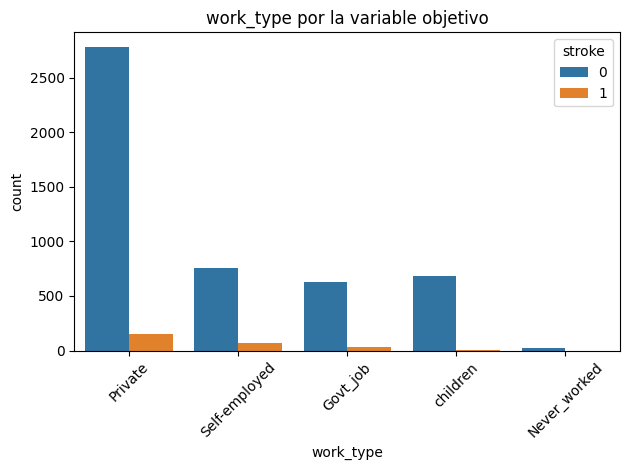

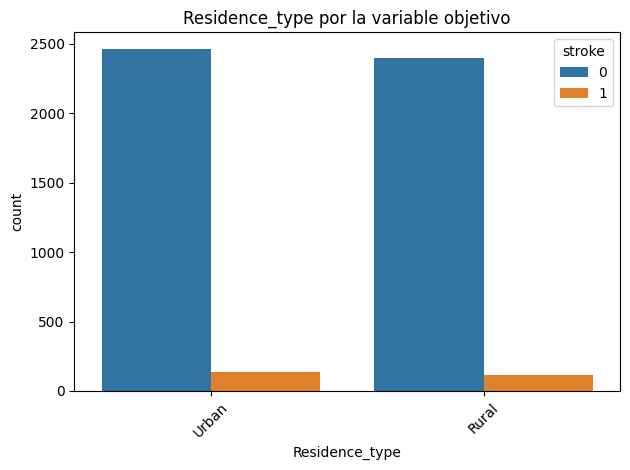

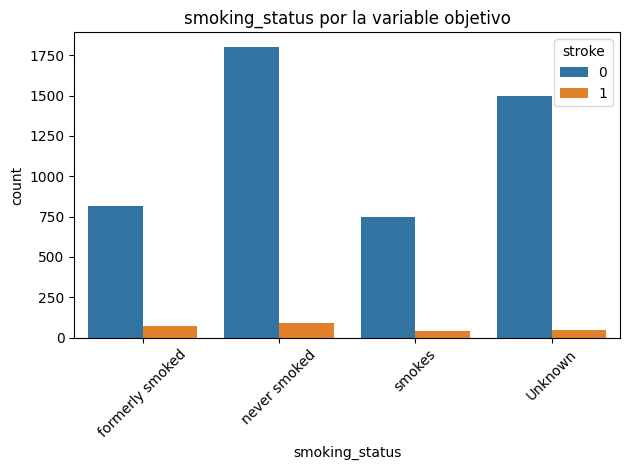

In [167]:
for col in categorical_columns:
    plt.figure()
    sns.countplot(data=df, x=col, hue='stroke')
    plt.xticks(rotation=45)
    plt.title(f"{col} por la variable objetivo")
    plt.tight_layout()
    plt.show()

### Relaciones entre variables numéricas y la variable objetivo

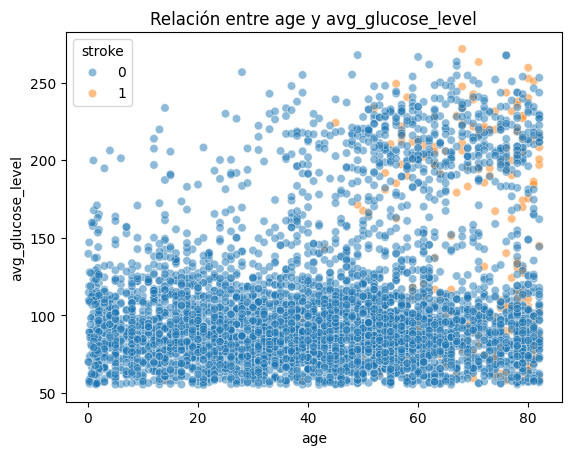

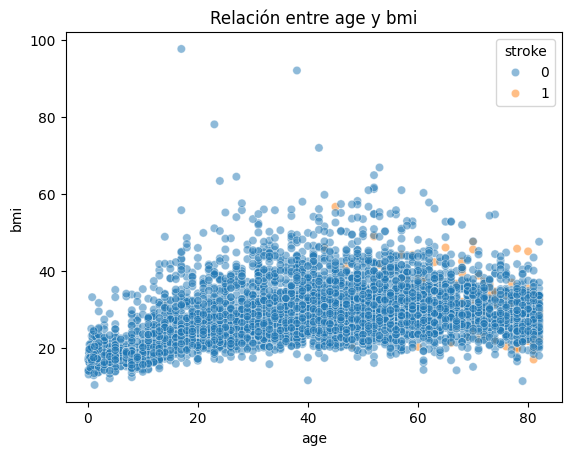

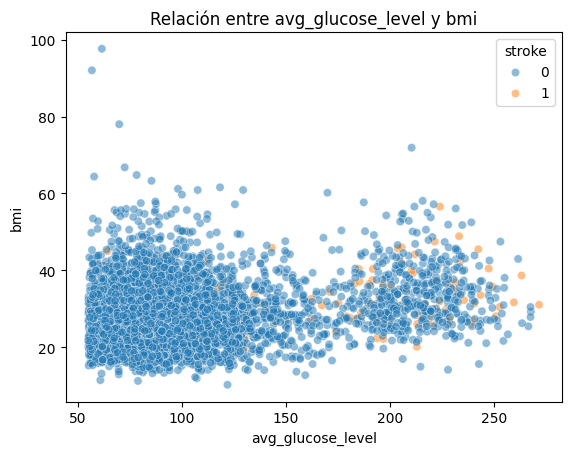

In [168]:
for i in range(len(numeric_columns)):
    for j in range(i+1, len(numeric_columns)):
        x = numeric_columns[i]
        y = numeric_columns[j]

        plt.figure()
        sns.scatterplot(data=df, x=x, y=y, hue='stroke', alpha=0.5)
        plt.title(f"Relación entre {x} y {y}")
        plt.show()

### Matriz de correlación entre variables numéricas y la variable objetivo

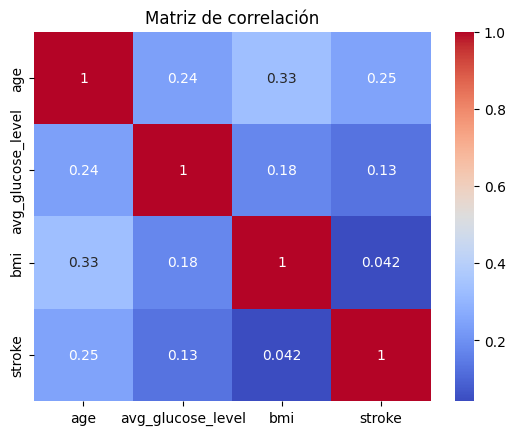

In [169]:
plt.figure()
sns.heatmap(df[[*numeric_columns, 'stroke']].corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()

## Preprocesamiento de Datos e Ingeniería de Características

### Tranformacion de variables numericas
Se transforman las variables numéricas nulas, sustituyéndolas por la media de la variable. Se normalizan las variables numéricas para que tengan una media de 0 y una desviación estándar de 1.

In [170]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

### Transformación de variables categóricas
Se transforman las variables categóricas nulas, sustituyéndolas por la moda de la variable. Se convierten las variables categóricas en variables numéricas utilizando la codificación one-hot.

In [171]:
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

### Creacion del pipeline para el preprocesamiento
Se crea un pipeline para el preprocesamiento de los datos, que incluye la transformación de variables numéricas y categóricas. Se utiliza la clase `ColumnTransformer` de `sklearn` para aplicar diferentes transformaciones a diferentes columnas del DataFrame.

In [172]:
preprocesor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_columns),
        ("cat", categorical_transformer, categorical_columns),
    ]
)

## Desarrollo y Evaluación de Modelos

In [173]:
# Eliminar las columnas que no se usarán
X = df.drop(["id", "stroke"], axis=1)
# Obtener la columna objetivo
y = df["stroke"]

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Definir los modelos a evaluar
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight="balanced"),
    "SVM (Support Vector Machine)": SVC(probability=True, class_weight="balanced"),
}

# Cross-validation y metricas a evaluar
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

### Entrenamiento y validación de los modelos

In [174]:
normal_results = {key: {} for key in models.keys()}

# Evaluar los modelos con validación cruzada
for key, value in models.items():
    pipeline = Pipeline(
        steps=[("preprocessor", preprocesor), ("classifier", clone(value))]
    )

    # Realizar la validación cruzada
    scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring=metrics,
        n_jobs=-1,
        return_train_score=False,
    )
    # Entrenar el modelo
    pipeline.fit(X_train, y_train)
    # Guardar los resultados
    normal_results[key]["estimator"] = pipeline
    normal_results[key]["metrics"] = {metric: scores[f"test_{metric}"].mean() for metric in metrics}

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [175]:
# Mostrar los resultados
results_df = pd.DataFrame({key: value["metrics"] for key, value in normal_results.items()}).T.sort_values(
    "f1", ascending=False
)
display(results_df)

,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.739239,0.133078,0.788974,0.227713,0.838741
SVM (Support Vector Machine),0.748042,0.121322,0.668333,0.205288,0.795066
Decision Tree,0.918538,0.135535,0.120256,0.127270,0.539815
Random Forest,0.950342,0.166667,0.010000,0.018826,0.789644


## Ajuste de Hiperparámetros y Selección de Modelos

### Establecimiento de los modelos y parametros a buscar

In [176]:
model_params = {
    "Logistic Regression": {
        "classifier__C": [0.01, 0.1, 1, 10],
        "classifier__penalty": ["l2"],
        "classifier__solver": ["lbfgs"],
    },
    "Decision Tree": {
        "classifier__max_depth": [5, 10, 15],
        "classifier__min_samples_split": [2, 10, 20],
    },
    "Random Forest": {
        "classifier__n_estimators": [40, 50, 55, 65],
        "classifier__max_depth": [9, 10, 11],
        "classifier__min_samples_split": [22, 25, 30, 35],
    },
    "SVM (Support Vector Machine)": {
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ["linear", "rbf"],
        "classifier__gamma": ["scale", "auto"],
    },
}

### Busqueda de hiperparámetros

In [177]:
best_results = {key: {} for key in models.keys()}

# Buscar los mejores hiperparámetros para cada modelo
for key, value in models.items():
    pipe = Pipeline(
        steps=[("preprocessor", preprocesor), ("classifier", clone(value))]
    )
    grid_search = GridSearchCV(
        pipe, model_params[key], scoring="f1", cv=cv, n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train, y_train)

    # Evaluar el modelo con los mejores hiperparámetros
    scores = cross_validate(
        grid_search.best_estimator_,
        X_train,
        y_train,
        cv=cv,
        scoring=metrics,
        n_jobs=-1,
        return_train_score=False,
    )
    best_results[key] = {
        "estimator": grid_search.best_estimator_,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_,
        "metrics": {metric: scores[f"test_{metric}"].mean() for metric in metrics},
    }

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [178]:
# Mostrar los resultados
results_df = pd.DataFrame(best_results).T.sort_values("best_score", ascending=False)
display(results_df[["best_params", "best_score"]])

,best_params,best_score
Random Forest,"{'classifier__max_depth': 10, 'classifier__min...",0.267007
Logistic Regression,"{'classifier__C': 0.01, 'classifier__penalty':...",0.228669
SVM (Support Vector Machine),"{'classifier__C': 10, 'classifier__gamma': 'sc...",0.221229
Decision Tree,"{'classifier__max_depth': 10, 'classifier__min...",0.221214


### Comparacion de los modelos sin los mejores hiperparámetros y con los mejores hiperparámetros

In [179]:
comparacion = {}

for m in models.keys():
    if m not in comparacion:
        comparacion[m] = {}

    for metric in metrics:
        comparacion[m][f"{metric.capitalize()} (Normal)"] = normal_results[m]["metrics"][metric]
        comparacion[m][f"{metric.capitalize()} (Ajustado)"] = best_results[m]["metrics"][metric]

results_df = pd.DataFrame(comparacion).T
display(results_df)


,Accuracy (Normal),Accuracy (Ajustado),Precision (Normal),Precision (Ajustado),Recall (Normal),Recall (Ajustado),F1 (Normal),F1 (Ajustado),Roc_auc (Normal),Roc_auc (Ajustado)
Logistic Regression,0.739239,0.730432,0.133078,0.132925,0.788974,0.819231,0.227713,0.228669,0.838741,0.839859
Decision Tree,0.918538,0.805275,0.135535,0.137834,0.120256,0.562179,0.127270,0.221214,0.539815,0.702648
Random Forest,0.950342,0.840995,0.166667,0.172546,0.010000,0.592949,0.018826,0.267007,0.789644,0.834034
SVM (Support Vector Machine),0.748042,0.725785,0.121322,0.128400,0.668333,0.799103,0.205288,0.221229,0.795066,0.838249


### Graficos


=== Logistic Regression ===
Normal:
              precision    recall  f1-score   support

           0     0.9864    0.7438    0.8481       972
           1     0.1384    0.8000    0.2360        50

    accuracy                         0.7466      1022
   macro avg     0.5624    0.7719    0.5420      1022
weighted avg     0.9449    0.7466    0.8181      1022

Hiperparámetros:
              precision    recall  f1-score   support

           0     0.9862    0.7366    0.8433       972
           1     0.1351    0.8000    0.2312        50

    accuracy                         0.7397      1022
   macro avg     0.5607    0.7683    0.5373      1022
weighted avg     0.9446    0.7397    0.8134      1022



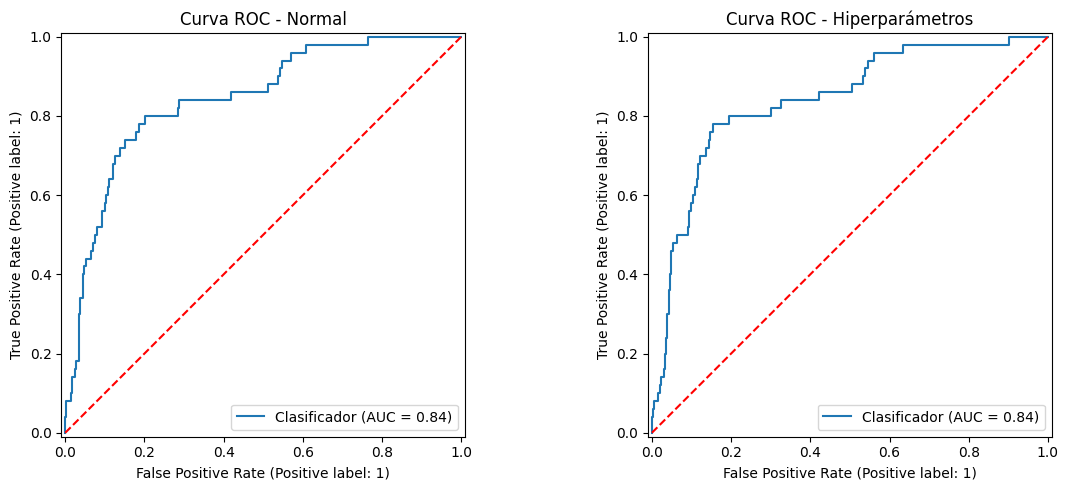

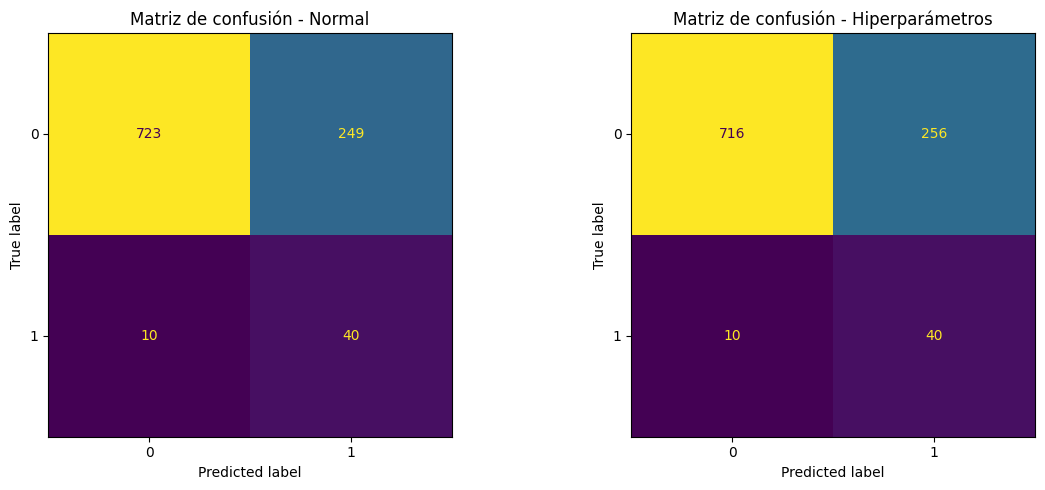


=== Decision Tree ===
Normal:
              precision    recall  f1-score   support

           0     0.9556    0.9733    0.9643       972
           1     0.1875    0.1200    0.1463        50

    accuracy                         0.9315      1022
   macro avg     0.5715    0.5466    0.5553      1022
weighted avg     0.9180    0.9315    0.9243      1022

Hiperparámetros:
              precision    recall  f1-score   support

           0     0.9695    0.8179    0.8873       972
           1     0.1238    0.5000    0.1984        50

    accuracy                         0.8023      1022
   macro avg     0.5466    0.6590    0.5428      1022
weighted avg     0.9281    0.8023    0.8536      1022



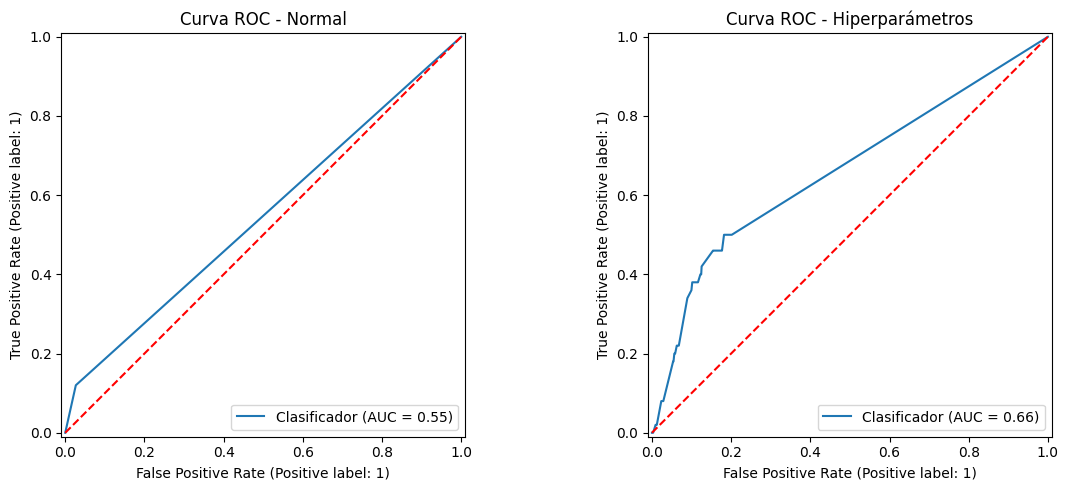

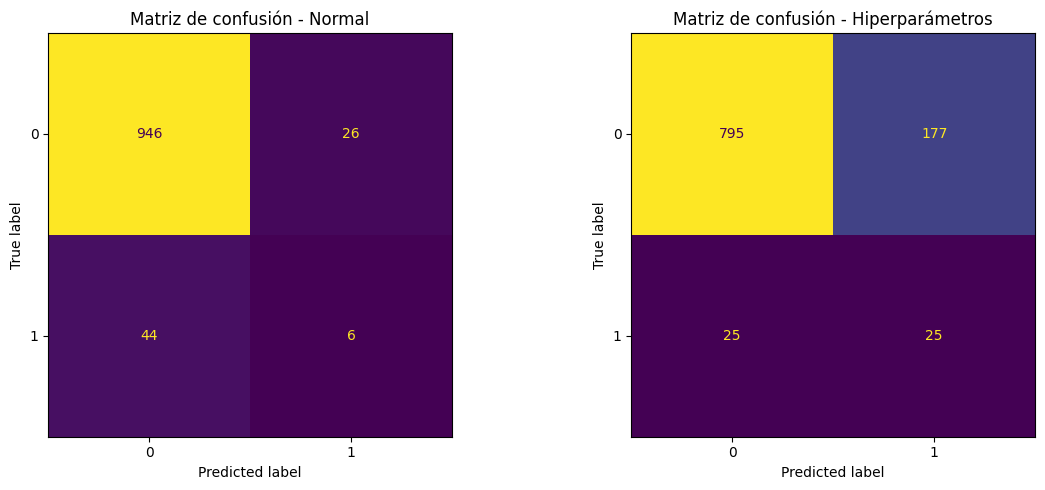


=== Random Forest ===
Normal:
              precision    recall  f1-score   support

           0     0.9510    0.9990    0.9744       972
           1     0.0000    0.0000    0.0000        50

    accuracy                         0.9501      1022
   macro avg     0.4755    0.4995    0.4872      1022
weighted avg     0.9045    0.9501    0.9267      1022

Hiperparámetros:
              precision    recall  f1-score   support

           0     0.9767    0.8632    0.9164       972
           1     0.1840    0.6000    0.2817        50

    accuracy                         0.8503      1022
   macro avg     0.5804    0.7316    0.5991      1022
weighted avg     0.9379    0.8503    0.8854      1022



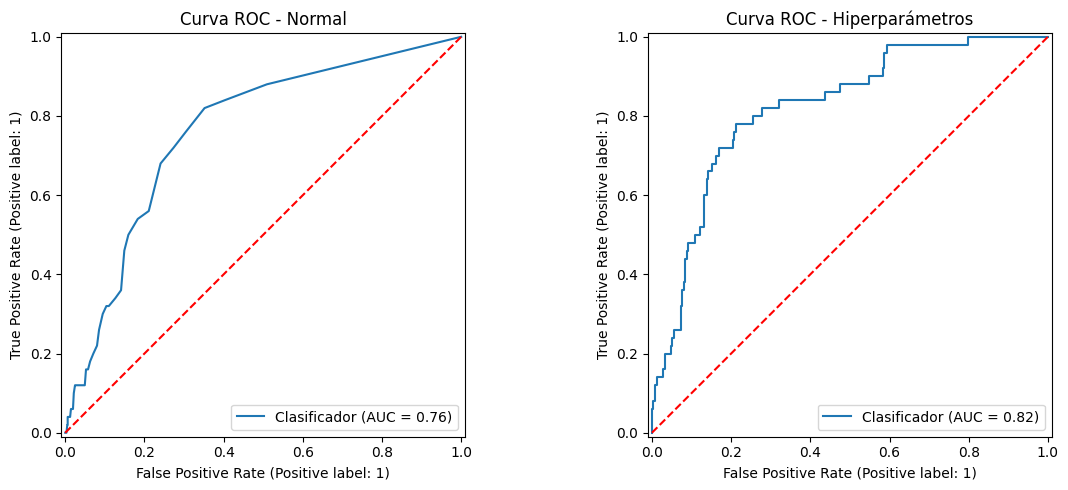

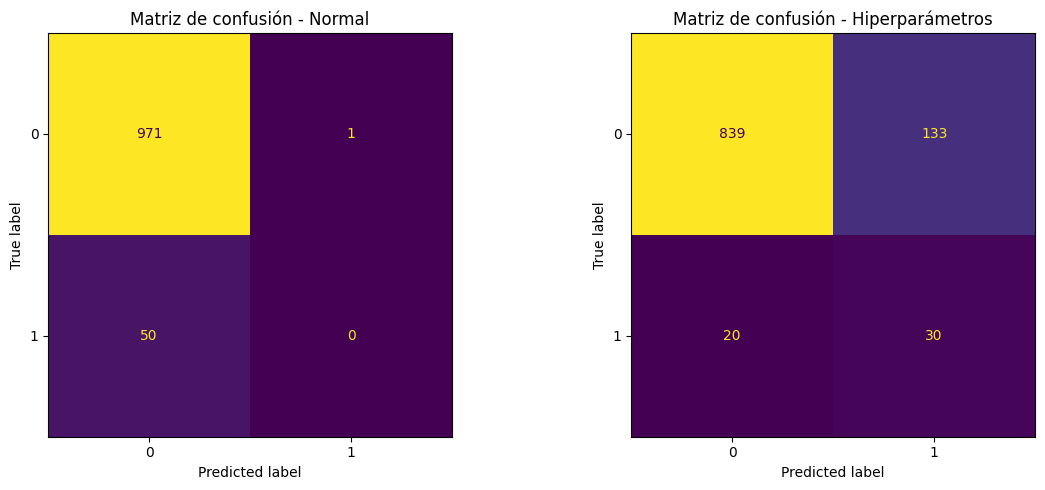


=== SVM (Support Vector Machine) ===
Normal:
              precision    recall  f1-score   support

           0     0.9777    0.7675    0.8599       972
           1     0.1274    0.6600    0.2136        50

    accuracy                         0.7622      1022
   macro avg     0.5526    0.7137    0.5368      1022
weighted avg     0.9361    0.7622    0.8283      1022

Hiperparámetros:
              precision    recall  f1-score   support

           0     0.9874    0.7284    0.8384       972
           1     0.1344    0.8200    0.2310        50

    accuracy                         0.7329      1022
   macro avg     0.5609    0.7742    0.5347      1022
weighted avg     0.9457    0.7329    0.8087      1022



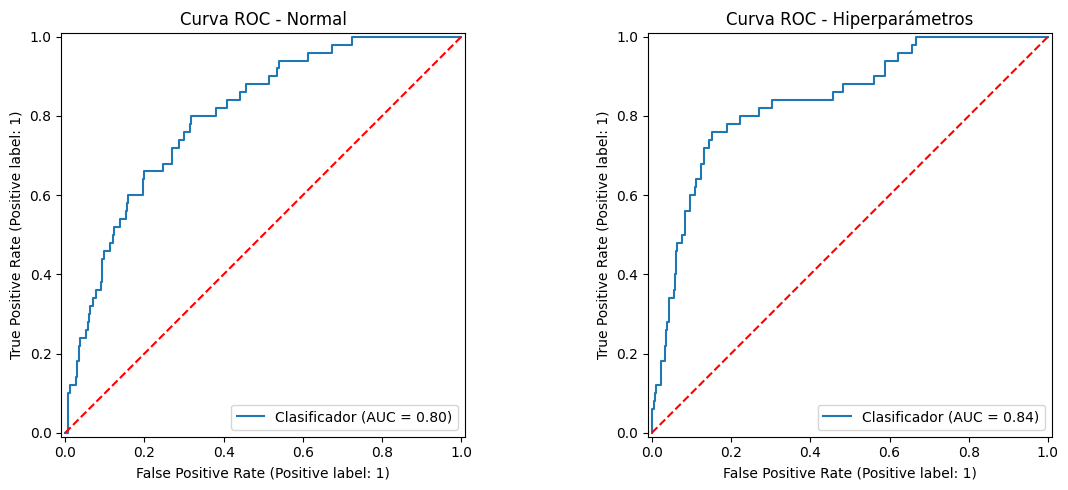

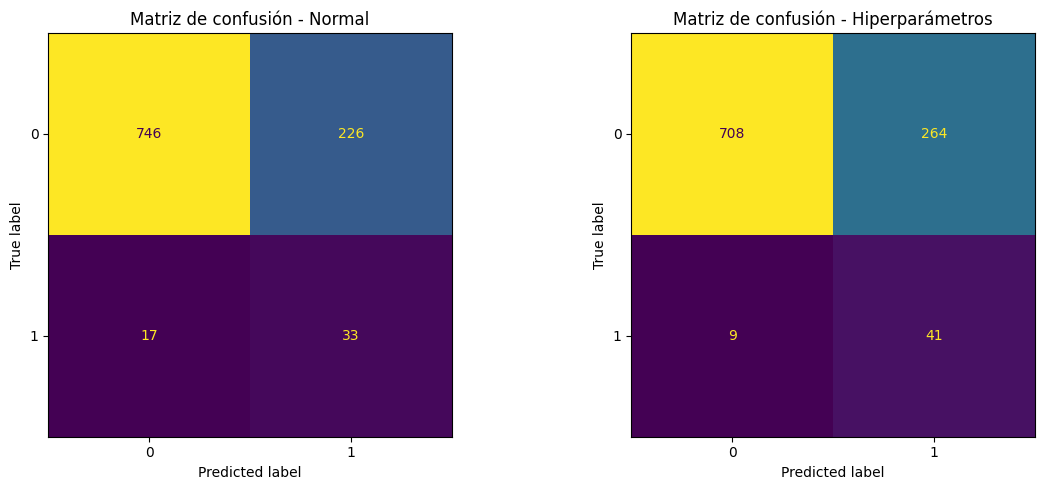

In [180]:
for key in models.keys():
    model1 = normal_results[key]["estimator"]
    model2 = best_results[key]["estimator"]

    # Predecir con ambos modelos
    y_pred_1 = model1.predict(X_test)
    y_pred_prob_1 = model1.predict_proba(X_test)[:, 1]
    y_pred_2 = model2.predict(X_test)
    y_pred_prob_2 = model2.predict_proba(X_test)[:, 1]

    # Reporte de clasificación
    print(f"\n=== {key} ===")
    print("Normal:")
    print(classification_report(y_test, y_pred_1, digits=4))
    print("Hiperparámetros:")
    print(classification_report(y_test, y_pred_2, digits=4))

    # Crear figura con dos columnas
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    RocCurveDisplay.from_predictions(y_test, y_pred_prob_1, ax=axes[0], name="Clasificador")
    axes[0].plot([0, 1], [0, 1], "r--")
    axes[0].set_title("Curva ROC - Normal")
    RocCurveDisplay.from_predictions(y_test, y_pred_prob_2, ax=axes[1], name="Clasificador")
    axes[1].plot([0, 1], [0, 1], "r--")
    axes[1].set_title("Curva ROC - Hiperparámetros")
    plt.tight_layout()
    plt.show()

    # Matriz de confusión
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_1, ax=axes[0], colorbar=False)
    axes[0].set_title("Matriz de confusión - Normal")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_2, ax=axes[1], colorbar=False)
    axes[1].set_title("Matriz de confusión - Hiperparámetros")
    plt.tight_layout()
    plt.show()



## Técnicas Avanzadas

### Uso de SMOTE en los modelos usados antes

In [181]:
smote_results = {key: {} for key in models.keys()}

# Evaluar los modelos con validación cruzada
for key, value in models.items():
    pipeline = ImbPipeline(
        steps=[
            ("preprocessor", preprocesor),
            ("smote", SMOTE(random_state=42)),
            ("classifier", clone(value)),
        ]
    )

    # Realizar la validación cruzada
    scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring=metrics,
        n_jobs=-1,
        return_train_score=False,
    )
    # Guardar los resultados
    smote_results[key]["metrics"] = {metric: scores[f"test_{metric}"].mean() for metric in metrics}

In [182]:
comparacion = {}

for m in models.keys():
    if m not in comparacion:
        comparacion[m] = {}

    for metric in metrics:
        comparacion[m][f"{metric.capitalize()} (Normal)"] = normal_results[m]["metrics"][metric]
        comparacion[m][f"{metric.capitalize()} (SMOTE)"] = smote_results[m]["metrics"][metric]

results_df = pd.DataFrame(comparacion).T
display(results_df)

,Accuracy (Normal),Accuracy (SMOTE),Precision (Normal),Precision (SMOTE),Recall (Normal),Recall (SMOTE),F1 (Normal),F1 (SMOTE),Roc_auc (Normal),Roc_auc (SMOTE)
Logistic Regression,0.739239,0.742417,0.133078,0.130949,0.788974,0.758974,0.227713,0.223304,0.838741,0.835915
Decision Tree,0.918538,0.881118,0.135535,0.118832,0.120256,0.225897,0.127270,0.155505,0.539815,0.570264
Random Forest,0.950342,0.925881,0.166667,0.124411,0.010000,0.085256,0.018826,0.101047,0.789644,0.782635
SVM (Support Vector Machine),0.748042,0.807484,0.121322,0.115805,0.668333,0.447564,0.205288,0.183909,0.795066,0.773608


### Clasificador Gradiente Boosting + SMOTE

In [183]:
# Pipeline con SMOTE (generación de muestras sintéticas)
pipeline = ImbPipeline(
    steps=[
        ("preprocessor", preprocesor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", GradientBoostingClassifier(random_state=42)),
    ]
)

# Validación cruzada con el pipeline que incluye SMOTE
cv_scores = cross_validate(
    pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring=metrics,
    n_jobs=-1,
    return_train_score=False,
)

# Mostrar los resultados de la validación cruzada
results_df = pd.DataFrame(
    {metric: cv_scores[f"test_{metric}"].mean() for metric in metrics},
    index=["GradientBoosting + SMOTE"]
)
display(results_df)

,accuracy,precision,recall,f1,roc_auc
GradientBoosting + SMOTE,0.877202,0.145996,0.316667,0.199704,0.798629
